In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras import backend as K
#from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import keras

import math
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

#To run project notebooks in subfolders as from root folder
import sys
sys.path.append('../../')

###Import self-written library
from featexlib import Debug as dbug
from featexlib import *

#for autorealoading the submodules
%load_ext autoreload
%autoreload 2

In [ ]:
###ACTIVE CELL
###MAKING Scaler, weight analyse
def training_preprocessor(n_train=None, 
                         dataset_dir = "../../Data/scrapid/training_data/", 
                         dataset_name="scrapid_11c_256x256_1638_noraw_1", 
                         dataset_path = None, 
                         scaler_dir='../../models/scalers/', 
                         scaler_name='scaler', 
                         scaler_path=None,
                         weight_calc=True,
                         load_extra=False):

    x_load, y_load = None,None
    
    if load_extra:
        x_load, y_load, _ = Image_generator.load_data(save_dir = dataset_dir, name=dataset_name, path=dataset_path)
    else:
        x_load, y_load = Image_generator.load_data(save_dir = dataset_dir, name=dataset_name, path=dataset_path)

    if n_train is not None:
        x_load = x_load[:n_train]
        y_load = y_load[:n_train]

    #Balance calcualation
    if weight_calc:
        balance_table = np.array([np.mean(np.argmax(y_load, axis=-1) == c) for c in range(y_load.shape[-1])])
        print('Class balance:')
        print(balance_table)
        
    #Scaler    
    scaler = StandardScaler()
    
    print('Fitting scaler on dataset with shape',x_load.shape)
    
    print('Mean before scaler',x_load.mean())
    
    x_train_sc = scaler.fit_transform(x_load.reshape(x_load.shape[0],-1))
    
    print('Mean value after scaler',x_train_sc.mean())
    
    scaler_path = scaler_path if scaler_path is not None else os.path.join(scaler_dir, "%s.pkl"%(scaler_name))
    print('Scaler exported to',scaler_path)
    
    pickle.dump(scaler, open(scaler_path,'wb'))

    
training_preprocessor(n_train=1440, 
                             dataset_dir = "../../Data/scrapid/training_data/", 
                             dataset_name="scrapid_11c_256x256_1638_noraw_1", 
                             scaler_dir = '../../models/scalers/', 
                             scaler_name='scrapid_11c_256x256_1440_1_unet_scaler_v1'
                            )


In [2]:
###ACTIVE CELL#####
sp_y_is_rgb = False
num_of_classes = 11 #Must be fixed
batch_size = 2      
#List of codes for RGB y, do not change the order!
list_of_codes_colors = [
    0, #Black
    64, #Dark red
    32896, #Yellow
    8388608, #Blue
    32768, #Green
    192, #Red
    8388736, #Violet
    4194448, ##????
    20624, ##????
    52443, ##????
    10911041, ##????
]
###Enter custom balance table if you want:
balance_table = np.array([6, 0, 2, 1.8,1, 1, 1, 1, 1, 1, 1])
#################################################
list_of_codes = list_of_codes_colors
###FOR ONE CHANNEL Y
if not sp_y_is_rgb:
    list_of_codes = [i for i in range(num_of_classes)]
    
###Set dataset balancing
def get_balanced_weight(inp, norm=False):
    norm_inp =  inp/inp.sum()
    
    num_classes = len(inp)
    
    ideal = 1/num_classes
    
    k_arr = np.array([(ideal/i) if i != 0 else 0 for i in norm_inp] )
    
    if norm:
        return k_arr/k_arr.sum()
    else:
        return k_arr

################################

class_weights = get_balanced_weight(balance_table)
print('Weight table:')
print(class_weights)

Weight table:
[0.25454545 0.         0.76363636 0.84848485 1.52727273 1.52727273
 1.52727273 1.52727273 1.52727273 1.52727273 1.52727273]


In [12]:
###ACTIVE CELL
###Creating DataGenerator
###DataGenerator class defenition
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir="../../Data/", preprocess_pipeline=None, batch_size=32, file_filter_regex = r'/([^/]+)\.npy', recursive=True):
        
        def get_data_file(arr):
            while True:
                for i in arr:
                    yield i 
                    
        self.actual_data_file_path = get_data_file([f for f in glob.glob(f"{data_dir}/**", recursive=recursive) if os.path.isfile(f) and re.search(file_filter_regex, f)])
        self.actual_data_set = None
        self.batch_size = batch_size
        self.data_len = None
        self.preprocess_pipeline = preprocess_pipeline
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.data_len / self.batch_size))

    def __getitem__(self, index):
        return self.x[index*self.batch_size:(index+1)*self.batch_size], self.y[index*self.batch_size:(index+1)*self.batch_size]

    def on_epoch_end(self):
        actual_data_file_path = self.actual_data_file_path.__next__()
        self.x, self.y = Image_generator.load_data(path = actual_data_file_path)
        self.data_len = len(self.x)
        
        if self.preprocess_pipeline is not None:
            self.x, self.y = self.preprocess_pipeline(self.x, self.y)   
            
###Creating DataGenerator object    
data = DataGenerator(data_dir="../../Data/scrapid/training_data_temp/",
                     batch_size = batch_size,
                     preprocess_pipeline = Image_generator(
                        Image_generator.Pipeline_x_y_images(
                            common_layers = [
                                Image_generator.Mod_scaler(file='../../models/scalers/scrapid_11c_256x256_1440_1_unet_scaler_v1.pkl', target="x"),
                                Image_generator.Mod_astype('float32'),
                                #Image_generator.Mod_duplicate(num=1)
                                #Image_generator.Mod_reshape(shape=(-1,256,256,3),target="x"),
                            ],
                            special_layers = [[
                                Image_generator.Mod_shuffle(),
                                Image_generator.Mod_shift(sh_h=100, sh_v=100, rand = True, interpolation_saved = cv.INTER_NEAREST, borderValue=0, borderValue_saved=0),
                                Image_generator.Mod_rotate(angle=180, rand = True, interpolation_saved = cv.INTER_NEAREST, borderValue=0, borderValue_saved=0),
                                Image_generator.Mod_one_hot( list_of_codes, rgb_mode = sp_y_is_rgb, target="y"),

                            ]]
                        )
                    )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


getItemindex 0


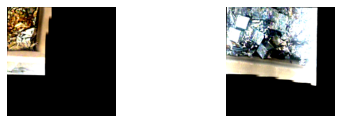

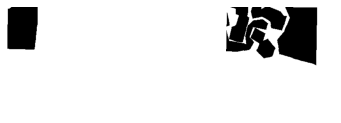

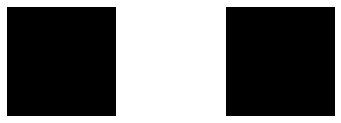

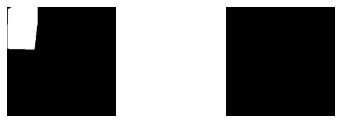

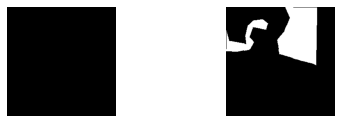

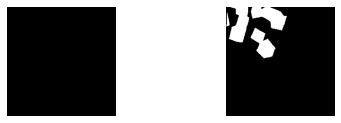

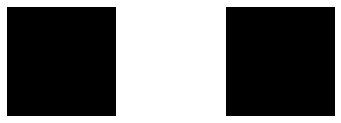

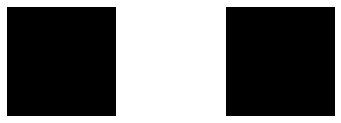

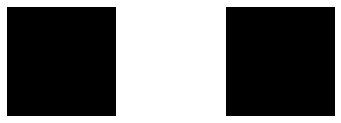

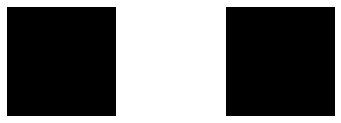

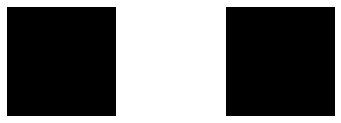

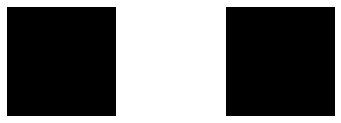

In [5]:
####DEBUG CELL
#data.on_epoch_end()
tmp_x, tmp_y = data.__getitem__(0)

dbug.show_images_list(tmp_x[:4,...], col_number = 4)
for c in range(tmp_y.shape[-1]):
        dbug.show_images_list(tmp_y[:4,..., c], col_number = 4)

In [7]:
###ACTIVE CELL####
#Model
#Prepare model transfer-learned VGG16

K.clear_session()
def unet(pretrained_weights = None,input_size = (256,256,3), full_train=False):
    VGG16_weight = "../../models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    VGG16 = tf.keras.applications.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_size)
    last_layer = VGG16.output
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = full_train
            
    model_ = tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2, 2), padding='same')(last_layer)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)    
    
    concat_1 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block5_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1), padding='same')(concat_1)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_2 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1), padding='same')(concat_2)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(512,(3,3),strides=(2, 2), padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_3 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1), padding='same')(concat_3)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_4 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block2_conv2").output])
    
    model_ = tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1), padding='same')(concat_4)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_5 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block1_conv2").output])
    
    model_ = tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1), padding='same')(concat_5)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1), padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2D(11,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    #model_ = tf.keras.layers.Softmax()(model_)

    model_ = tf.keras.Model(VGG16.input,model_)
    
    model_.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4), loss=weightedLoss(tf.keras.losses.CategoricalHinge(), class_weights), metrics=[Mean_IOU_tensorflow_2])
    #model_.compile(optimizer='sgd', loss=weightedLoss(tf.keras.losses.MeanSquaredError(), class_weights), metrics=[Mean_IOU_tensorflow_2])
    #model_.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError(), metrics=[Mean_IOU_tensorflow_2])
    
    #model_.compile(optimizer ='sgd', loss = 'categorical_hinge', metrics = [Mean_IOU_tensorflow_2])
    #model_.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'categorical_hinge', metrics = ['accuracy'])
    #model_.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    if(pretrained_weights):
        model_.load_weights(pretrained_weights)
    
    return model_

def Mean_IOU_tensorflow_2(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    void_labels = K.equal(K.sum(y_true, axis=-1), 0)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(true_pixels, i) & ~void_labels
        pred_labels = K.equal(pred_pixels, i) & ~void_labels
        inter = tf.cast(true_labels & pred_labels, tf.int32)
        union = tf.cast(true_labels | pred_labels, tf.int32)
        legal_batches = K.sum(tf.cast(true_labels, tf.int32), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(ious[legal_batches]))
    iou = tf.stack(iou)
    legal_labels = ~tf.math.is_nan(iou)
    iou = iou[legal_labels]
    return K.mean(iou)


def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.cast(K.argmax(true, axis=axis), tf.int32) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [8]:
####ACTIVE CELL#####
#New training
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
####ACTIVE CELL#####
###Continue model training
model = unet()
model.load_weights('../../models/scrapid_11c_256x256_120_1_unet_acc_cpu')
model.summary()

/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 768, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 768, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [9]:
####ACTIVE CELL#####
#Initialise checkpointer
checkpointer = tf.keras.callbacks.ModelCheckpoint('../../models/scrapid_11c_256x256_120_1_unet_vgg16.h5', verbose=1, mode='auto', monitor='loss',save_best_only=True)


In [10]:
x_, y_ = data.__getitem__(0)
y_.shape

getItemindex 0


(2, 256, 256, 11)

In [11]:
####ACTIVE CELL#####
model.fit(data, batch_size=batch_size, epochs=2, steps_per_epoch = 3, callbacks=[checkpointer],shuffle=False)

getItemindex 0
Epoch 1/2
getItemindex 0
getItemindex 1
3/3 [==============================] - ETA: 0s - loss: 1.2699 - Mean_IOU_tensorflow_2: 0.0465
Epoch 00001: loss improved from inf to 1.26991, saving model to ../../models/scrapid_11c_256x256_120_1_unet_vgg16.h5
3/3 [==============================] - 17s 5s/step - loss: 1.2699 - Mean_IOU_tensorflow_2: 0.0465
Epoch 2/2
getItemindex 0
getItemindex 1
3/3 [==============================] - ETA: 0s - loss: 1.4965 - Mean_IOU_tensorflow_2: 0.0643
Epoch 00002: loss did not improve from 1.26991
3/3 [==============================] - 12s 4s/step - loss: 1.4965 - Mean_IOU_tensorflow_2: 0.0643


<ipython-input-15-bf3eb6d02591>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=data,


InvalidArgumentError:  Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 8, computed = 24 spatial_dim: 2 input: 48 filter: 3 output: 8 stride: 2 dilation: 1
	 [[node model_1/conv2d_transpose_5/conv2d_transpose
 (defined at /home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/backend.py:5530)
]] [Op:__inference_train_function_12458]

Errors may have originated from an input operation.
Input Source operations connected to node model_1/conv2d_transpose_5/conv2d_transpose:
In[0] model_1/conv2d_transpose_5/stack (defined at /home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/layers/convolutional.py:1333)	
In[1] model_1/conv2d_transpose_5/conv2d_transpose/ReadVariableOp:	
In[2] model_1/block5_pool/MaxPool (defined at /home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/layers/pooling.py:357)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 358, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-14-36a97cb786a4>", line 2, in <module>
>>>     model.fit(data, batch_size=batch_size, epochs=1, steps_per_epoch = 1, callbacks=[checkpointer])
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/layers/convolutional.py", line 1334, in call
>>>     outputs = backend.conv2d_transpose(
>>> 
>>>   File "/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/backend.py", line 5530, in conv2d_transpose
>>>     x = tf.compat.v1.nn.conv2d_transpose(x, kernel, output_shape, strides,
>>> 

In [25]:
###NOT USED##########
#fit model for big data
#model.fit_generator(GenerateInputs(xs,ys), epochs=31, verbose=1,callbacks=[checkpointer],
#                     steps_per_epoch=8,shuffle=True)

In [14]:
###Save model after training
model.save_weights('../../models/scrapid_11c_768x256_273_1_unet_acc_gpu')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 768, 64  1792        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 768, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

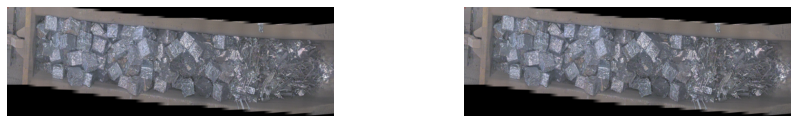

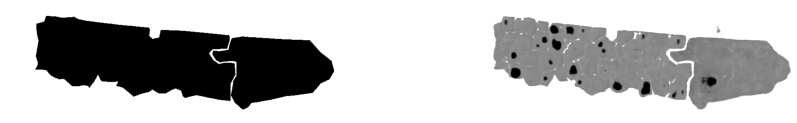

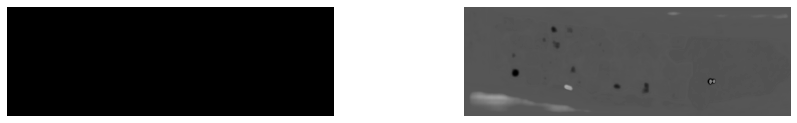

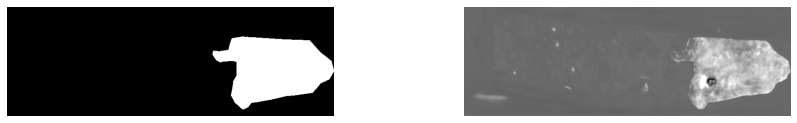

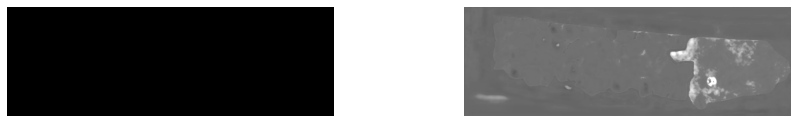

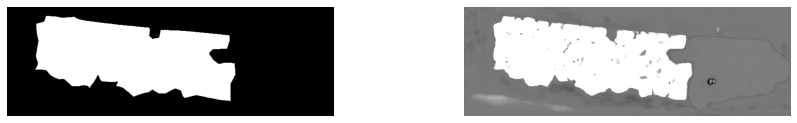

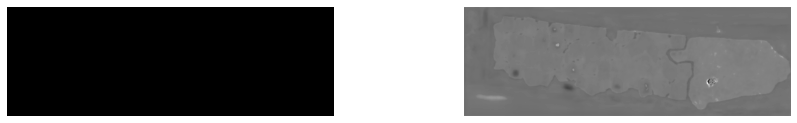

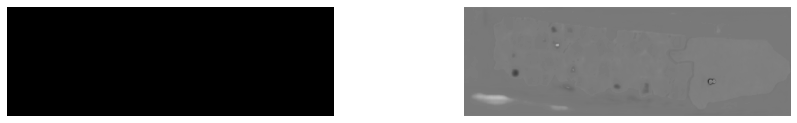

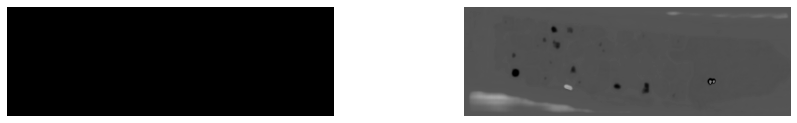

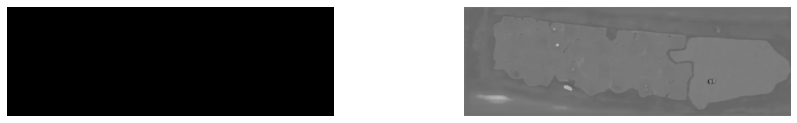

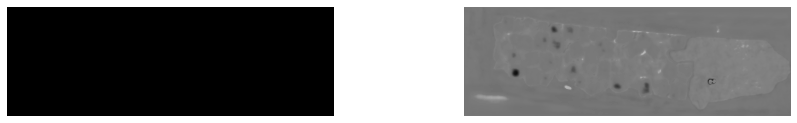

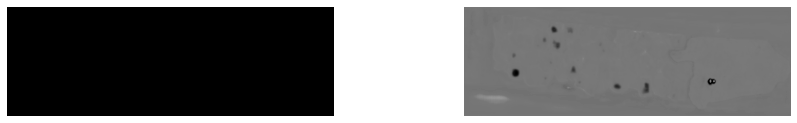

In [10]:
def show_predict(x,x_orig,y_orig, number):
    y_pred = model(x[number].reshape(-1,pic_h,pic_w,pic_ch)).numpy()
    y_pred = (np.clip(((y_pred - y_pred.mean() + y_pred.std())/y_pred.std())*127, 0,255)).astype('int16')
    dbug.show_images_list([x_orig[number],x_orig[number]], col_number = 2)
    for c in range(y_orig.shape[-1]):
        dbug.show_images_list([y_orig[number,...,c].reshape(pic_h,pic_w,1), y_pred[...,c].reshape(pic_h,pic_w,1)], col_number = 2) 


numm = 0
show_predict(xs_test,x_test,y_test, numm)

In [11]:
####ACTIVE CELL#####
#Helpful functions for showing result

#List of codes, should be the same as in training
list_of_codes_colors = [
    0, #Black
    64, #Dark red
    32896, #Yellow
    8388608, #Blue
    32768, #Green
    192, #Red
    8388736, #Violet
    4194448, ##????
    20624, ##????
    52443, ##????
    10911041, ##????
]
#Help function to get RGB codes from DEC
def get_rgb_from_codes(inp):
    return np.array([[i//65536,(i - 65536*(i//65536))//256, i - 65536*(i//65536) - 256*((i - 65536*(i//65536))//256)] for i in inp]).astype(np.uint8)

list_of_colors = get_rgb_from_codes(list_of_codes_colors)


def show_predict_multi(x,x_orig,y_orig, number):
    
    y_pred = model(x[number].reshape(-1,pic_h,pic_w,pic_ch)).numpy()
    
    res_r = np.argmax(y_pred, axis=3)
    res_g = np.copy(res_r)
    res_b = np.copy(res_r)



    for c in range(y_pred.shape[-1]):
        res_r[res_r == c] =  list_of_colors[c,0]
        res_g[res_g == c] =  list_of_colors[c,1]
        res_b[res_b == c] =  list_of_colors[c,2]

    res = np.concatenate([res_r[...,None],res_g[...,None],res_b[...,None]], axis=3)
    
    
    for c in range(res.shape[0]):
        dbug.show_images_list([x_orig[number][c,...],res[c,...],y_orig[number][c,...]],col_number = 3)
        #dbug.show_images_list(res[c,...],col_number = 3)
        #dbug.show_images_list(y_orig[number][c,...],col_number = 3)

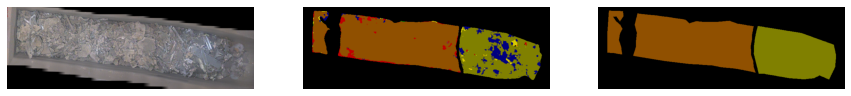

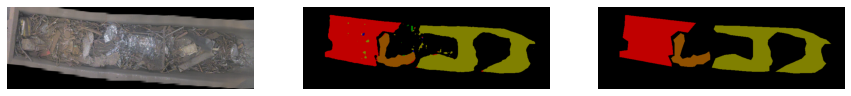

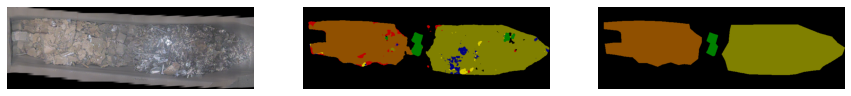

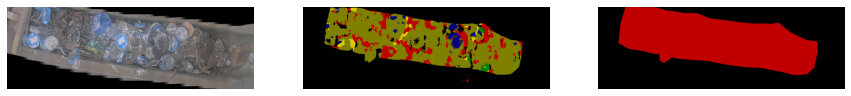

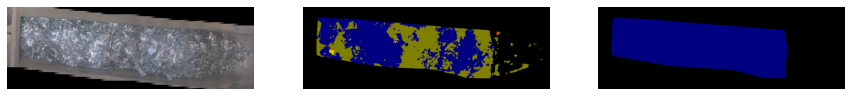

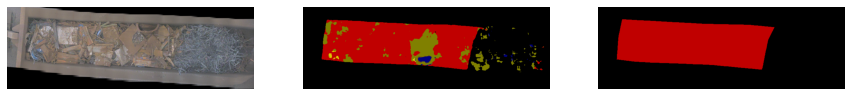

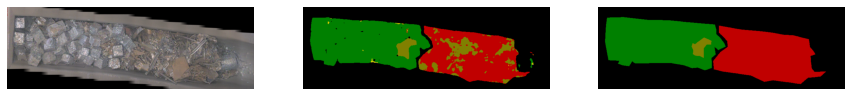

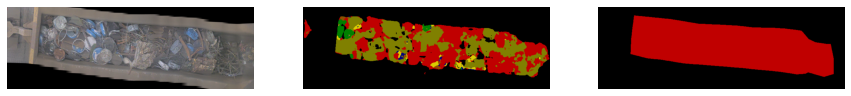

In [12]:
####ACTIVE CELL###########
####Show result in train dataset

num = [0,1,2,3,4,5,6,7]
show_predict_multi(xs,x_train,y_train_raw,num)        

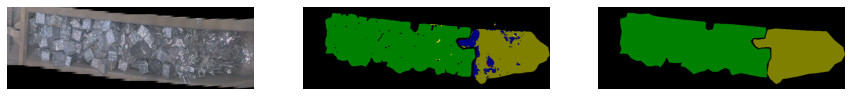

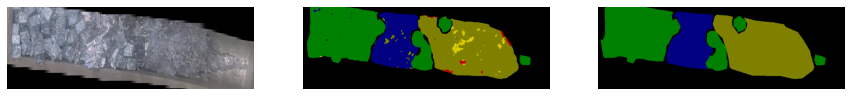

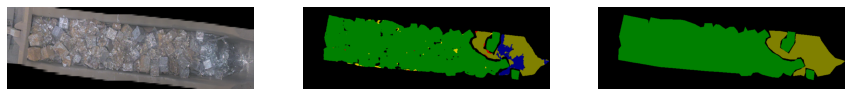

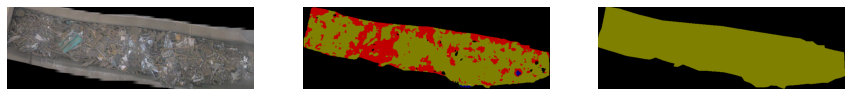

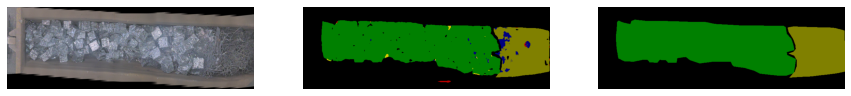

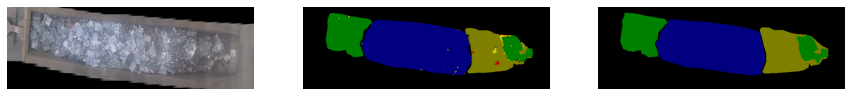

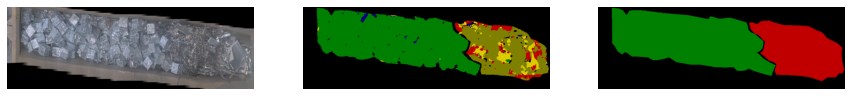

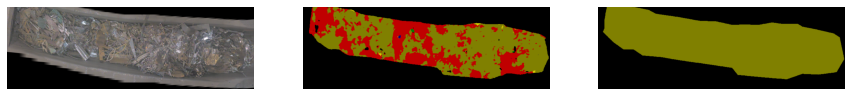

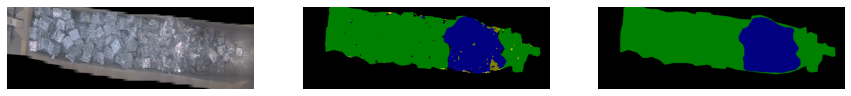

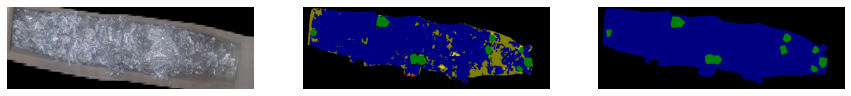

In [14]:
####ACTIVE CELL###########
####Show result in test dataset

num = [0,1,2,3,4,5,6,7,8,9]
show_predict_multi(xs_test,x_test,y_test_raw,num)   